# Introduction
In the previous posts, we calculated accessibility in terms of distance. Distance is an excellent metric for driving or walking on flat land. For short travels by car or walking on flat land, distance can be directly converted to travel time. Most people have an intuitive understanding of their average driving speeds (50 km/h for residential roads in New Zealand) or their approximate walking speed on flat land (usually around 5 km / h for a fit adult as given in [Section 3.4 in NZTA pedestrian planning and design guide](https://www.nzta.govt.nz/assets/resources/pedestrian-planning-guide/docs/pedestrian-planning-guide.pdf)). Hills are not an issue for drivers provided road quality and safety are no different to flat land. But hills do impact travel time for pedestrians; which in turn impacts accessibility. 

> _This post will consider the impact of hills on walking travel time to playgrounds in Wellington suburbs._

Playgrounds are key amenities that can impact the quality of life for young families. Since they are also frequently accessed on foot, it's important to consider how accessible they really are. Particularly for suburbs with a high residential fraction.   

## Tasks
- Calculate the impact of walking in hilly terrain on travel time to council playgrounds in Wellington
- Compare the travel times to playground for the largest residential suburbs in Wellington
- Model the average travel time to a playground by suburb 


## Technical details
To do this analysis, we need to overcome some technical aspects:
- Re-do accessibility analysis: from distance to travel time
- Get elevation data for roads and walkways
- Convert elevation to road / walkway inclination 
- Incorporate inclination in the accessibility analysis
    - Include road inclines in the pandana network
    - Estimate the impact of inclination on travel time
    


In [32]:
# Import some packages
import warnings
import pandas as pd
import osmnx as ox 
import networkx as nx
import pandana as pa

import geopandas 
import numpy as np
import seaborn as sns
import folium
import yaml
from importlib import reload
from shapely.geometry import Point, Polygon, LineString
from descartes import PolygonPatch
import matplotlib.pyplot as plt
import pystan

import utils.data_processing as dp
import utils.accessibility_analysis as aa
import utils.util as ut
import utils.stan_utils as su

# Some configs
warnings.filterwarnings('ignore')
ox.config(log_console=True, use_cache=True)
pd.set_option('display.max_columns', 200)
%matplotlib inline

In [4]:
# Define bounding box (W, S, E, N) for the area of Wellington we're interested in
# Copied from http://boundingbox.klokantech.com/
general_bbox = [174.57,-41.38,174.84,-41.1527]

# Separate out the bounding box list into 4 vertices. 
south = general_bbox[1]
west = general_bbox[0]
north = general_bbox[3]
east = general_bbox[2]

# Set OSM bounding box
osm_bbox = [south, west, north, east]

# centroids of bounding box
mean_lat = np.mean([north, south])
mean_lon = np.mean([west, east])

# Load datasets

There are 3 key datasets used in this analysis:
- *WCC playground locations*: downloaded as a zip file
- *Suburb boundaries for Wellington*
    - StatsNZ 2013 Statistical Area 2 boundaries: downloaded as a geodatabase (gdb)
    - StatsNZ 2013 meshblocks: downloaded  as a geodatabase (gdb). Used for easy filtering of the Statistical Area 2 boundaries 
- *Wellington street network*
    - without elevation: using OpenStreetMap via *pandana*
    - with elevation: using OpenStreetMap and Google Elevation API via *osmnx*



## WCC Playgrounds

In [5]:
wcc_playgrounds = geopandas.read_file('zip://./data/WCC_Playgrounds.zip')
wcc_playgrounds['lon'] = wcc_playgrounds['geometry'].apply(lambda p: p.x)
wcc_playgrounds['lat'] = wcc_playgrounds['geometry'].apply(lambda p: p.y)
wcc_playgrounds = wcc_playgrounds.to_crs(epsg=4167)

In [6]:
map_playground = folium.Map(location=[mean_lat, mean_lon], zoom_start = 11)

for each in wcc_playgrounds.iterrows():
    folium.Marker(location = [each[1]['lat'],each[1]['lon']]).add_to(map_playground)

map_playground

## Suburb boundaries

In [7]:
wcc_suburbs = geopandas.read_file('zip://./data/WCC_Suburbs_Boundaries.zip')
wcc_suburbs_proj = wcc_suburbs.to_crs(epsg=4167)

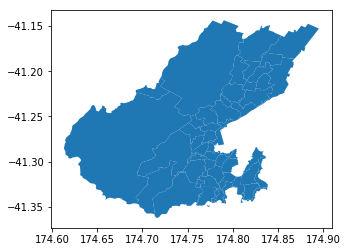

In [8]:
wcc_suburbs_proj.plot()

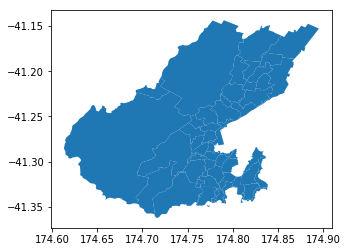

In [9]:
wcc_suburbs.plot()

## Meshblocks

In [10]:
meshblock= geopandas.read_file('./data/meshblock-higher-geographies-2019-generalised.gdb')
wlg_meshblock = meshblock.query('UR2019_V1_00_NAME == "Wellington"')
wlg_meshblock_suburbs = geopandas.sjoin(wcc_suburbs, wlg_meshblock, op='contains', how='right')

(174.71, 174.76)

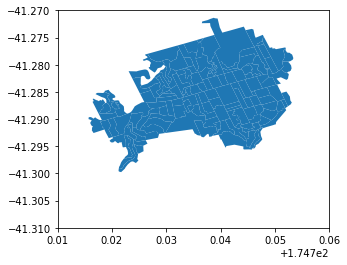

In [11]:
wlg_meshblock_suburbs.query('suburb == "Karori"').plot()
plt.ylim(-41.310, -41.270)
plt.xlim(174.71, 174.76)

(174.71, 174.76)

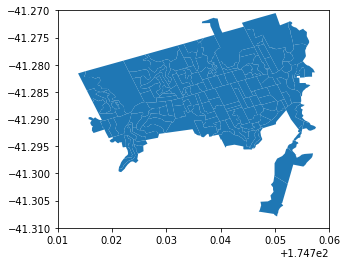

In [12]:
wlg_meshblock_suburbs_1 = geopandas.sjoin(wlg_meshblock, wcc_suburbs, op='intersects')
wlg_meshblock_suburbs_1.query('suburb == "Karori"').plot()
plt.ylim(-41.310, -41.270)
plt.xlim(174.71, 174.76)

(174.71, 174.76)

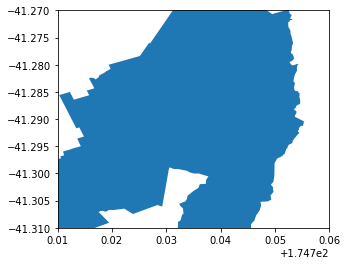

In [13]:
wcc_suburbs.query('suburb == "Karori"').plot()
plt.ylim(-41.310, -41.270)
plt.xlim(174.71, 174.76)

## Wellington street network: without elevation
Getting the Wellington street network in a form suitable for accessibility analysis is trivial. The previous posts [on fuel station](https://shriv.github.io/Fuel-Stations-Analysis-Part-3/) and [playground](https://shriv.github.io/Playgrounds-vs-pubs/) acessibility cover the process in detail. Without delving into the specifics, the process basically involves calling _pandana's_ OpenStreetMap loader. And voila, we have a street network that can be consumed by _pandana_ for the accessibility analysis. 

In [14]:
# Set some parameters for accessibility analysis
n = 1 # nth closest nodes to fuel station. n = 1 means the closest.
distance = 5000.0 # distance bound for accessibility calculation; impedance limit.
num_pois = 10

# Plotting parameters
bbox_aspect_ratio = (osm_bbox[2] - osm_bbox[0]) / (osm_bbox[3] - osm_bbox[1])
fig_kwargs = {'facecolor':'w', 
              'figsize':(10, 10 * bbox_aspect_ratio)}

bmap_kwargs={'epsg':'4167','resolution':'f'}
plot_kwargs={'cmap':'viridis_r','s':4,'edgecolor':'none'}

The _pandana_ network above has edge weights in the default units of metres, which means that the accessibility analyses will also be in metres. We can post-hoc convert the distance units to travel time with an average walking speed of 5 km/h or, 83 m/minute if we want travel time in minutes. 

## Wellington street network: with elevation

In [16]:
# Open the API keys stored in a YAML file
with open("utils/api_keys.yaml", 'r') as stream:
    data_loaded = yaml.load(stream)

# Get Google Elevation API key
google_elevation_api_key = data_loaded['google_elevation_api_key'][0]

# Create an OSMNX walking street netwoek for the Wellington bounding box
G = ox.graph_from_bbox(north, south, east, west, network_type='walk')

# Add elevation values for the nodes in the OSMNX graph
G = ox.add_node_elevations(G, api_key=google_elevation_api_key)

# Generate an edge grade (inclination) with the elevations at the nodes
G = ox.add_edge_grades(G)

# Accessibility analysis using network with street gradients

## Reproducing existing accessibility analysis

In [17]:
# Get nodes and edges as geodataframes (gdfs) from OSMNX network
graph_df = ox.graph_to_gdfs(G)
nodes_gdfs = graph_df[0]
edges_gdfs = graph_df[1]

In [18]:
# Setting indices of Edges gdfs to match expected dataframe for Pandana
edges_gdfs['from_idx'] = edges_gdfs['u']
edges_gdfs['to_idx'] = edges_gdfs['v']
edges_gdfs= edges_gdfs.set_index(['from_idx', 'to_idx'])
edges_gdfs.index.names= ['','']

# Setting indices of Nodes gdfs to match expected dataframe for Pandana
nodes_gdfs.index.name = 'id'

## Converting distance to travel time

A [simple search](https://books.google.co.nz/books?id=SyulBQAAQBAJ&pg=PA160&lpg=PA160&dq=walking+speed+gradient+accessibility&source=bl&ots=iKmtg73TIV&sig=ACfU3U3N5CAAtqoA0QzfSpJubylfjneWtA&hl=en&sa=X&ved=2ahUKEwiqqeKj3YTgAhVQXn0KHdSFDWsQ6AEwAHoECAkQAQ#v=onepage&q=walking%20speed%20gradient%20accessibility&f=false) led me to [Naismith's Rule](https://en.wikipedia.org/wiki/Naismith%27s_rule) and then to [Tobler's Hiking Function](https://en.wikipedia.org/wiki/Tobler%27s_hiking_function) to calculate travel time as a function of distance and gradient. 

I've chosen to go with Tobler's without too much rationale other than its simple form. Tobler's hiking function for speed, $\nu$, is a shifted exponential with three parameters: $a$, $b$ and $c$ which give the fastest speed, speed retardation due to gradient and shift from zero respectively. 

$$
\nu = a\exp^{\left(-b.|slope~+~c|\right)}
$$

Note that $slope$ here is the dimensionless quantity: $\frac{dh}{dx}$ (or, rise / run). Tobler's function can also be written with slope in degrees ($^{\circ}$). Speed in km/h can be converted to a travel time in minutes with the factor (60/1000). 

While I haven't read Tobler's original paper, a [brief exposition of other equivalent functional forms to Tobler's](https://rpubs.com/chrisbrunsdon/hiking) has been written up by Chris Brunsdon. For a more rigorous analysis, we'll need to refit the form above (or similar) as Brunsdon does for different types of pedestrians. According to NZTA and various other studies, there is significant heterogeneity in walking speed; noth from the route (terrain, incline etc) and also the characteristics of the walker e.g. carrying things, footwear, and demographics. We can likely imagine that a commuter will walk at a very different speed to a father taking his children to the playground during the daytime. Brunsdon's analysis itself shows a very different relationship to Tobler's. 

Function | a | b | c 
--- | --- | --- | ---
Tobler | 6 | 3.5 | 0.05 
Brunsdon | 3.557 | 2.03 | 0.133


## Pandana network with travel times

# Dealing with MultiDiGraph
Osmnx generates an elevation graph as a multidigraph. That is, the edge (u,v) is also present as (v,u) with the _opposite_ gradient. This is why the average elevation profile is 0! 
For a travel time analysis, we need to split the components of the graph. 

In [19]:
edges_gdfs_undir_inv, edges_gdfs_undir, nodes_gdfs = dp.separate_elevation_graph_by_direction(G)

## Better travel time


In [20]:

# Create pandana network objects for flat and hilly terrain travel times
network = pa.Network(nodes_gdfs['x'], nodes_gdfs['y'],
                     edges_gdfs_undir['u'], edges_gdfs_undir['v'], 
                     edges_gdfs_undir[['time_5khr']])

network_hills = pa.Network(nodes_gdfs['x'], nodes_gdfs['y'],
                           edges_gdfs_undir['u'], edges_gdfs_undir['v'], 
                           edges_gdfs_undir[['time_tobler']])

network_hills_inv = pa.Network(nodes_gdfs['x'], nodes_gdfs['y'],
                               edges_gdfs_undir_inv['u'], edges_gdfs_undir_inv['v'], 
                               edges_gdfs_undir_inv[['time_tobler']])

In [21]:
# Calculate accessibility
playground_accessibility = aa.get_accessibility(network, wcc_playgrounds, distance=30, num_pois=10)
playground_hills_accessibility = aa.get_accessibility(network_hills, wcc_playgrounds, distance=30, num_pois=10)
playground_hills_inv_accessibility = aa.get_accessibility(network_hills_inv, wcc_playgrounds, distance=30, num_pois=10)

In [22]:
total_flat = (playground_accessibility[1] + playground_accessibility[1])
total_hills_1 = (playground_hills_inv_accessibility[1] + playground_hills_accessibility[1])
total_hills_2 = (playground_hills_inv_accessibility[2] + playground_hills_accessibility[2])


In [23]:
def filtered_accessibility_network(pandana_network, filtered_accessibility):

    network_nodes = pandana_network.nodes_df.reset_index()
    new_network_nodes = []
    for node in filtered_accessibility.reset_index()['id'].tolist():
        val = network_nodes[network_nodes['id'] == node]
        new_network_nodes.append(val)
    
    new_network_nodes = pd.concat(new_network_nodes).set_index('id')
    pandana_network.nodes_df = new_network_nodes
    return pandana_network, filtered_accessibility


# Accessibility by Wellington suburb

## Distributions within populous SA2 units

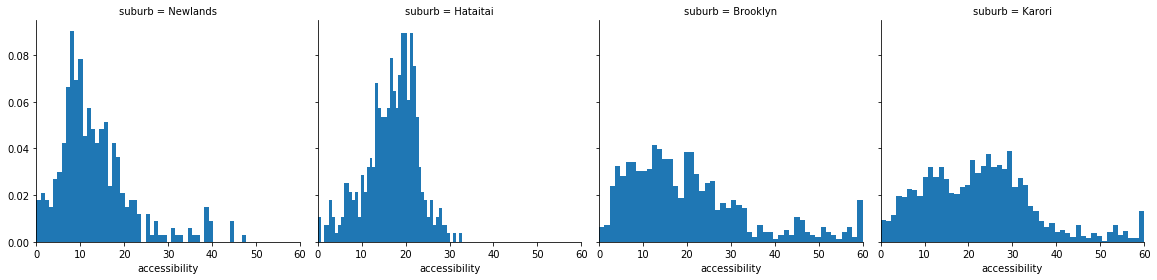

In [24]:
# Get lat and lon coordinates for accessibility values
orig_nodes = network_hills.nodes_df 
df_joined = pd.merge(orig_nodes.reset_index(), total_hills_1.reset_index(), how='inner')
df_joined.columns = ['node_id', 'lon', 'lat', 'accessibility']
# Convert lat and lon to geoseries
df_joined_coords = dp.coords_df_to_geopandas_points(df_joined, crs={'init': 'epsg:4167'})


playground_df = geopandas.sjoin(wcc_suburbs, df_joined_coords, op='contains').drop('index_right', axis=1)


#df_sel = playground_df[playground_df['AU2013_V1_00_NAME'].isin(['Karori Park', 'Te Kainga',
#                                          'Karori South', 'Karori East',
#                                         'Newlands South', 'Hataitai North', 
#                                          'Strathmore Park', 'Raroa',
#                                         'Ngaio South', 'Brooklyn'])]

df_sel = playground_df[playground_df['suburb'].isin(['Karori','Newlands', 'Hataitai', 'Strathmore','Brooklyn'])]

g = sns.FacetGrid(col='suburb', data=df_sel, size=4, col_wrap=5)
g.map(plt.hist, 'accessibility', normed=True, bins=50)
plt.xlim(0,60);
#plt.ylim(0, 0.0035);

## Visualising accessibility with composite SA2 boundaries

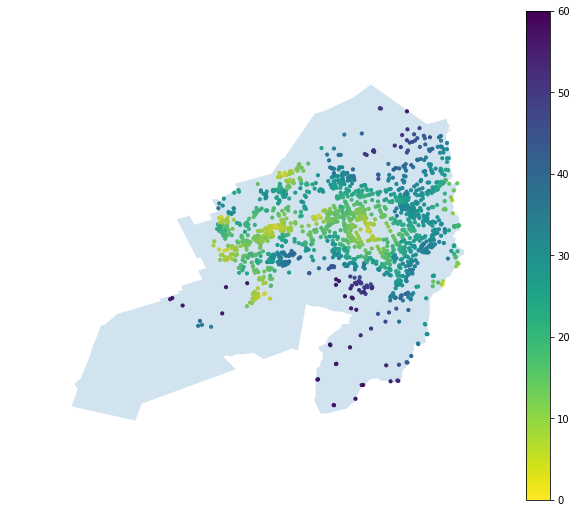

In [25]:
karori = playground_df[playground_df['suburb'] == 'Karori']
karori_mesh = wlg_meshblock_suburbs[wlg_meshblock_suburbs['suburb'] == "Karori"]

fig = plt.figure(figsize=(10,9))
#f, ax = plt.subplots()
ax = fig.add_subplot(1,1,1)
a0 = ax.scatter(karori['lon'], 
                karori['lat'], 
                s=10,
                c=karori['accessibility'],
                cmap='viridis_r')

#wlg_meshblock_suburbs[wlg_meshblock_suburbs['suburb'] == 'Karori'].plot(ax=ax, alpha=0.9)    
wcc_suburbs[wcc_suburbs['suburb'] == 'Karori']['geometry'].plot(ax=ax, alpha=0.2)   

cbar1 = fig.colorbar(a0, ax=ax)
ax.axis('off')
cbar1.set_clim(0, 60)
plt.show()

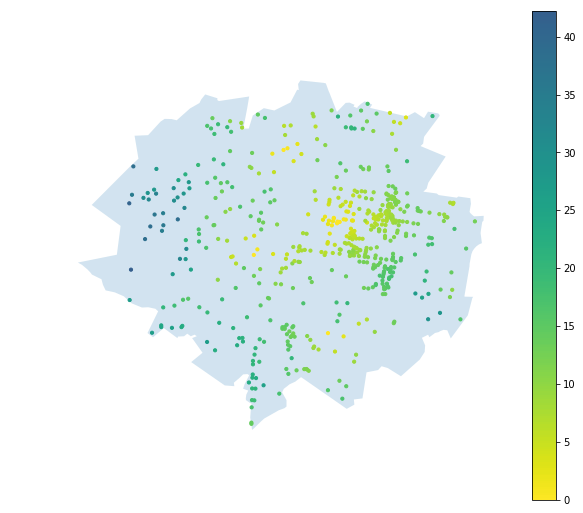

In [26]:
jville = playground_df[playground_df['suburb'] == 'Johnsonville']

fig = plt.figure(figsize=(10,9))
#f, ax = plt.subplots()
ax = fig.add_subplot(1,1,1)

wcc_suburbs[wcc_suburbs['suburb'] == 'Johnsonville']['geometry'].plot(ax=ax, alpha=0.2)    
#wlg_meshblock_suburbs[wlg_meshblock_suburbs['suburb'] == 'Johnsonville'].plot(ax=ax)    

a0 = ax.scatter(jville['lon'], 
                jville['lat'], 
                s=10,
                c=jville['accessibility'],
                cmap='viridis_r')

cbar1 = fig.colorbar(a0, ax=ax)
cbar1.set_clim(0, 60)
ax.axis('off')
plt.show()

In [27]:
wlg_meshblock_acc = geopandas.sjoin(wlg_meshblock,  df_joined_coords, op='contains')

In [28]:
wlg_meshblock_acc['SA22019_V1_00_NAME'].value_counts().head()

Miramar South            531
Pipitea-Kaiwharawhara    490
Karori Park              413
Karori South             412
Karori East              384
Name: SA22019_V1_00_NAME, dtype: int64

In [29]:
wlg_meshblock_acc['SA22019_V1_00_NAME'].value_counts().tail()

Grenada Village     74
Tawa North          71
Khandallah North    69
Onslow              57
Broadmeadows        52
Name: SA22019_V1_00_NAME, dtype: int64

# Stan experiments

In [67]:
norm_code = """
data {
    int n;
    real y[n];  
}
transformed data {}
parameters {
    real<lower=0, upper=60> mu;
    real<lower=0, upper=20> sigma;
}
transformed parameters {}
model {
    y ~ normal(mu, sigma);
}
generated quantities {
    real y_pred;
    y_pred = normal_rng(mu, sigma);
}

"""
model = pystan.StanModel(model_code=norm_code)
su.save(model, 'norm_model.pic')
norm_model = su.load('norm_model.pic')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd7effe6678d8ba2b4f8db3071b0d7d6 NOW.


In [112]:
# Run precompiled model
hataitai = playground_df[playground_df['suburb'] == 'Hataitai']
karori = playground_df[playground_df['suburb'] == 'Karori']
karori = karori[karori['accessibility'] > 0]

karori_dat = {'n': karori.shape[0],
              'y': karori['accessibility'].values,}
karori_fit = norm_model.sampling(karori_dat, chains=4)
print(karori_fit)


Inference for Stan model: anon_model_bd7effe6678d8ba2b4f8db3071b0d7d6.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      22.62  5.4e-3    0.3  22.01  22.41  22.62  22.82  23.21   3213    1.0
sigma   12.62  4.0e-3   0.22  12.19  12.47  12.61  12.76  13.07   3093    1.0
y_pred  22.65     0.2   12.6  -1.94  14.35  22.57  30.95  47.97   4000    1.0
lp__    -4887    0.02   0.96  -4890  -4888  -4887  -4887  -4886   1566   1.01

Samples were drawn using NUTS at Tue Mar  5 15:28:14 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


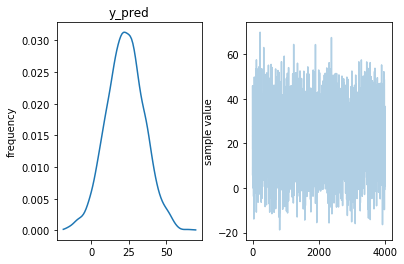

In [113]:
fig = karori_fit.plot(pars=['y_pred'])
fig.subplots_adjust(hspace=1.0, wspace=0.3)

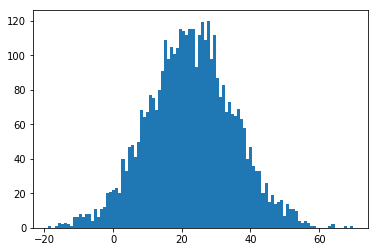

In [114]:
plt.hist(karori_fit['y_pred'], bins=100);

In [87]:
# Run precompiled model
hataitai = playground_df[playground_df['suburb'] == 'Hataitai']

hataitai_dat = {'n': hataitai.shape[0],
                'y': hataitai['accessibility'].values,}
hataitai_fit = norm_model.sampling(hataitai_dat, chains=4)
print(hataitai_fit)


Inference for Stan model: anon_model_bd7effe6678d8ba2b4f8db3071b0d7d6.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      16.79  5.4e-3   0.28  16.26   16.6  16.79  16.98  17.35   2675    1.0
sigma    5.89  3.9e-3   0.21   5.51   5.75   5.89   6.03   6.32   2818    1.0
y_pred  16.86    0.09   5.85   5.59   12.9  16.81  20.72  27.95   4000    1.0
lp__   -963.8    0.02   0.99 -966.4 -964.2 -963.4 -963.1 -962.8   1969    1.0

Samples were drawn using NUTS at Tue Mar  5 15:16:57 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


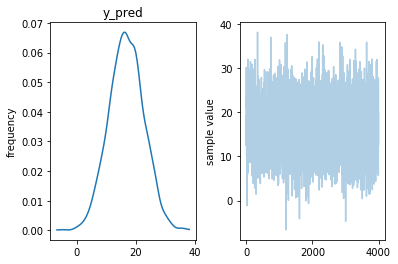

In [88]:
fig = hataitai_fit.plot(pars=['y_pred'])
fig.subplots_adjust(hspace=1.0, wspace=0.3)

## Truncated Normal

In [139]:
trunc_norm_code = """
functions {
    real normal_lb_rng(real mu, real sigma, real lb) {
        real p = normal_cdf(lb, mu, sigma);  // cdf for bounds
        real u = uniform_rng(p, 1);
        return (sigma * inv_Phi(u)) + mu;  // inverse cdf for value
    }
    real normal_lub_rng(real mu, real sigma, real lb, real ub) {
        real p_lb = normal_cdf(lb, mu, sigma);
        real p_ub = normal_cdf(ub, mu, sigma);
        real u = uniform_rng(p_lb, p_ub);
        real y = mu + sigma * Phi(u);
return y; }
}
data {
    int N;
    real L;
    real U;
    real<lower=L> y[N];
}
parameters {
    real<lower=0, upper=60> mu;
    real<lower=0, upper=20> sigma;
}
model {
    for (n in 1:N)
        y[n] ~ normal(mu, sigma) T[L,];
        }
generated quantities {
    real y_pred;
    y_pred = normal_lb_rng(mu, sigma, L);
}
"""

model = pystan.StanModel(model_code=trunc_norm_code)
su.save(model, 'trunc_norm_model.pic')
trunc_norm_model = su.load('trunc_norm_model.pic')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8b872905e60a1d353b7f1e71c79971df NOW.


In [140]:
# Run precompiled model
karori_trunc_dat = {'N': karori.shape[0],
                    'L': 0,
                    'U': 80,
                    'y': karori['accessibility'].values,}
karori_trunc_fit = trunc_norm_model.sampling(karori_trunc_dat, chains=4)
print(karori_trunc_fit)


Inference for Stan model: anon_model_8b872905e60a1d353b7f1e71c79971df.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu      20.07    0.01   0.52  19.04  19.73  20.07  20.42  21.04   1831    1.0
sigma   14.73  9.1e-3   0.39  14.01  14.45  14.71  14.99  15.52   1855    1.0
y_pred  22.41     0.2  12.62   1.69  13.01  21.47  30.68  49.36   4000    1.0
lp__    -4801    0.02   1.04  -4804  -4801  -4801  -4800  -4800   1817    1.0

Samples were drawn using NUTS at Wed Mar  6 08:16:36 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


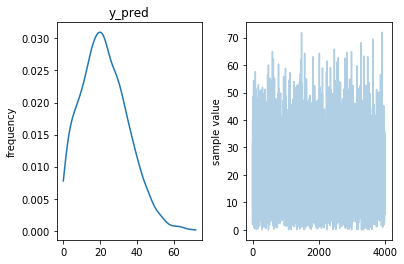

In [141]:
fig = karori_trunc_fit.plot(pars=['y_pred'])
fig.subplots_adjust(hspace=1.0, wspace=0.3)

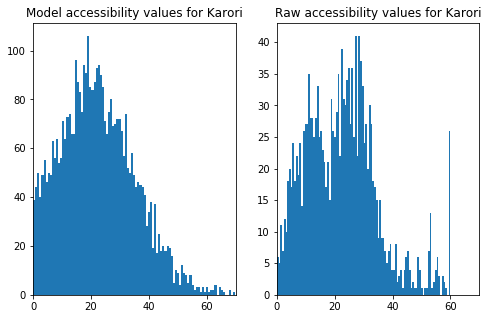

In [160]:
fig = plt.figure(figsize=(8, 5))
ax1 = fig.add_subplot(1,2,1)
ax1.hist(karori_trunc_fit['y_pred'], bins=100);
plt.title('Model accessibility values for Karori')
plt.xlim(0,70);

ax2 = fig.add_subplot(1,2,2)
ax2.hist(karori['accessibility'], bins=100);
plt.title('Raw accessibility values for Karori')
plt.xlim(0,70);

In [159]:
?plt.hist